# Processing data
Available at https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [159]:
import os
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import librosa

import torch
from torch import nn
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from IPython.display import Audio

# from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm

In [3]:
AUDIO_ROOT = './data/audio'
SAMPLE_LENGTH_MS = 5000 # All audio samples are 30 seconds long -> each sample can be 6 points

## Helpers for loading and transforming the data

In [ ]:
# TODO: Split audio into equal length segments and make each a file

In [56]:
files = []
labels = []
for dirent in os.listdir(AUDIO_ROOT):
    dirpath = os.path.join(AUDIO_ROOT, dirent)
    if os.path.isdir(dirpath):
        for file in os.listdir(dirpath):
            path = os.path.join(dirpath, file)
            files.append(path)
            labels.append(dirent)

data = pd.DataFrame({'file': files, 'label': labels})
data['labelId'] = data.groupby('label', sort=False).ngroup()
data

,file,label,labelId
0,./data/audio/pop/pop.00027.wav,pop,0
1,./data/audio/pop/pop.00033.wav,pop,0
2,./data/audio/pop/pop.00032.wav,pop,0
3,./data/audio/pop/pop.00026.wav,pop,0
4,./data/audio/pop/pop.00030.wav,pop,0
...,...,...,...
995,./data/audio/jazz/jazz.00018.wav,jazz,9
996,./data/audio/jazz/jazz.00032.wav,jazz,9
997,./data/audio/jazz/jazz.00026.wav,jazz,9
998,./data/audio/jazz/jazz.00027.wav,jazz,9


In [78]:
class AudioHelper():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    # Convert into 2-channel
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))

    # Since Resample applies to a single channel, we resample one channel at a time
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

In [88]:
class AudioTransformations():
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # Generate a Mel Spectrogram 
    # It converts the audio file into a format that is more similar to how humans actually percieve audio
    @staticmethod
    def spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    @staticmethod
    def spectrogram_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

## Visualizers

In [112]:
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#preparing-data-and-utility-functions-skip-this-section
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

## Creating PyTorch data loader

In [89]:
class AudioDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 4000 # Truncating all audio clips to 4 seconds
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'file']
        class_id = self.df.loc[idx, 'labelId']

        aud = AudioHelper.open(audio_file)
        reaud = AudioHelper.resample(aud, self.sr)
        rechan = AudioHelper.rechannel(reaud, self.channel)
        # TODO: Instead of truncating can we make multiple samples from a single piece
        dur_aud = AudioHelper.pad_trunc(rechan, self.duration)
        
        shift_aud = AudioTransformations.time_shift(dur_aud, self.shift_pct)
        sgram = AudioTransformations.spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioTransformations.spectrogram_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

In [90]:
dataset = AudioDS(data)

# Random split of 80:20 between training and validation
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [126]:
d = next(iter(train_dl))

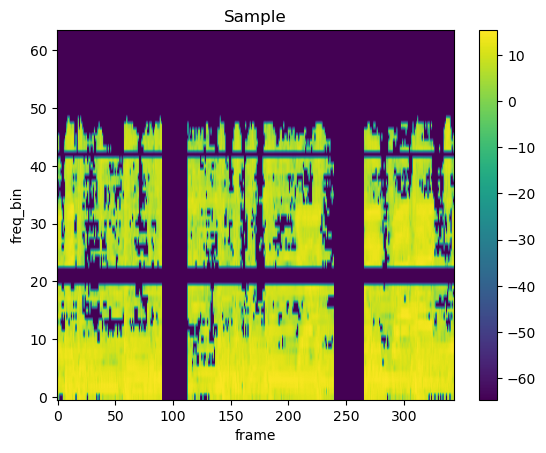

In [127]:
plot_spectrogram(d[0][0, 0, :, :], title='Sample')

# Models

## Simple classifier using CNN architecture

In [164]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv = nn.Sequential(self.conv1, self.relu1, self.bn1, self.conv2, self.relu2, self.bn2)
        
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=16, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        
        x = self.ap(x)
        
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        
        return x

## Transfer learning using pretrained Mel-Spectrogram classifier
https://huggingface.co/docs/transformers/model_doc/audio-spectrogram-transformer

# Training

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: %s" % device)

Using device: cpu


In [166]:
model = CNNClassifier()
model = model.to(device)

In [171]:
def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        # Repeat for each batch in the training set
        progress_bar = tqdm(train_dl, ascii = True)
        for i, (inputs, labels) in enumerate(progress_bar):
            print(data)
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((i + 1), loss.item()))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')

In [172]:
model = CNNClassifier()
model = model.to(device)

num_epochs = 2
training(model, train_dl, num_epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

[tensor([[[[ 33.0303,  30.3064,  29.8808,  ...,  31.6308,  30.5443,  30.8047],
          [ 31.1608,  31.6754,  30.5124,  ...,  30.9908,  32.2589,  32.3026],
          [ 26.1407,  25.8254,  27.6737,  ...,  25.3958,  27.9036,  28.9022],
          ...,
          [-23.8633, -38.9042, -38.9042,  ..., -38.9042, -38.9042, -36.5262],
          [-23.9685, -35.7127, -36.6868,  ..., -38.9042, -38.9042, -35.5017],
          [-24.8441, -36.8394, -37.2236,  ..., -38.9042, -38.9042, -35.1335]],

         [[ 33.0303,  30.3064,  29.8808,  ...,  31.6308,  30.5443,  30.8047],
          [ 31.1608,  31.6754,  30.5124,  ...,  30.9908,  32.2589,  32.3026],
          [ 26.1407,  25.8254,  27.6737,  ...,  25.3958,  27.9036,  28.9022],
          ...,
          [-23.8633, -38.9042, -38.9042,  ..., -38.9042, -38.9042, -36.5262],
          [-23.9685, -35.7127, -36.6868,  ..., -38.9042, -38.9042, -35.5017],
          [-24.8441, -36.8394, -37.2236,  ..., -38.9042, -38.9042, -35.1335]]],


        [[[  6.6128,   3.94

KeyboardInterrupt: 